Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['BTC', 'USDT']
intervals = ['1d']
period = '1 month ago UTC'
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install python-binance --upgrade --no-cache-dir
!pip install plotly stocktrends

Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from stocktrends import Renko
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, name, calculate, OHLC=False):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = None

    def update(self, dataset, plot=False):
        self.value = self.calculate(dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print("\n")
        print(self.name)
        print(value)
        plt.plot(value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print("\n")
        print(self.name)
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_base:
    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def calculate_renko(self, dataset, brick_size=1):
        renko_ = dataset[['open', 'high', 'low', 'close']].copy().astype(float)
        renko_.index.name = 'date'
        renko_ = Renko(renko_.reset_index())
        renko_.brick_size = brick_size
        renko_ = renko_.get_ohlc_data().set_index('date')
        renko_.index.name = 'time'
        return renko_.uptrend

    def calculate_heikin_ashi(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_RSI(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        threshold=1.75, 
                                        method='exponential'):

        volume = dataset[['volume']]
        volume_average = self._calculate_moving_average_(volume, window=average_1, method=method)
        relative_volume = volume / average_1
        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, window=average_2, method=method)
        relative_volume_level = smoothed_relative_volume.iloc[-1] / smoothed_relative_volume.iloc[-2]
        return relative_volume_level > threshold


class Cryptocurrency_indicators:
    def __init__(self, dataset, plot):
        self.indicators = Cryptocurrency_indicators_base()
        self.setup(self)
        self.update(dataset, plot=plot)

    def setup(self, cls):
        for cls in [cls.indicators, cls]:
            indicators = [indicator for indicator in dir(cls) if indicator.startswith('calculate_')]
            calculators = [getattr(cls, indicator) for indicator in indicators]

            for indicator, calculator in zip(indicators, calculators):
                setattr(cls, 
                        indicator[10:], 
                        Cryptocurrency_indicator(name=indicator[10:], 
                                                 calculate=calculator, 
                                                 OHLC=False))

    def update(self, dataset, plot=False):
        for cls in [self.indicators, self]:
            indicators = [indicator for indicator in dir(cls)]
            calculators = [getattr(cls, indicator) for indicator in indicators]

            for calculator in calculators:
                if isinstance(calculator, Cryptocurrency_indicator):
                    calculator.update(dataset, plot=plot)

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.calculate_simple_moving_average(dataset, window=1)
        heikin_ashi = self.indicators.calculate_heikin_ashi(heikin_ashi)
        heikin_ashi = self.indicators.calculate_exponential_moving_average(dataset, window=1)
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.calculate_RSI(dataset, span=6)
        RSI_12 = self.indicators.calculate_RSI(dataset, span=12)
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.calculate_KDJ(dataset)
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.calculate_bollinger_bands(dataset, period=20)
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.calculate_MACD(dataset)
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_buy_balance = self.quote_asset_balance / self.pair_last_price
        self.pair_sell_balance = self.base_asset_balance * self.pair_last_price
        self.pair_combined_base_balance = self.pair_buy_balance + self.base_asset_balance
        self.pair_combined_quote_balance = self.pair_sell_balance + self.quote_asset_balance

    def print_balance(self):
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, period=period, download=True, initial_plot=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = period
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, symbol=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators(self.dataset, plot=initial_plot)

    def download_dataset(self, client, symbol):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.pair = pair
        self.info = self.pair.info

        self.calculate_position()

    def calculate_position(self):
        if self.info.pair_buy_balance > self.info.base_asset_balance:
            self.position = 'sell'
        elif self.info.base_asset_balance > self.info.pair_buy_balance:
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.999999):
        if self.position == 'sell':
            coins_available = self.info.pair_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.info.pair_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        client.create_order(symbol=self.info.pair, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.pair.info.calculate_balance()
        self.pair.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 period=period, 
                 raw_price=True, 
                 download=True, 
                 initial_plot=True):

        self.period = period
        self.raw_price = raw_price
        self.download = download

        self.info = self.get_pair_info(client, pair)
        super().__init__(self)
        self.interval = self.get_datasets(client, intervals, initial_plot=initial_plot)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair)

    def get_datasets(self, client, intervals, initial_plot=True):
        dataset = dict()

        if self.raw_price:
            dataset['price'] = Cryptocurrency_pair_at_interval(client=client, 
                                                               info=self.info, 
                                                               interval='price', 
                                                               period=self.period, 
                                                               download=self.download, 
                                                               initial_plot=initial_plot)

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                period=self.period, 
                                                                download=self.download, 
                                                                initial_plot=initial_plot)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 period=period, 
                 raw_price=True, 
                 initial_plot=True):

        self.all_symbols = self.get_all_symbols(client)
        traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    period, 
                                    raw_price, 
                                    traded_pair_symbols, 
                                    initial_plot=initial_plot)

        self.traded_asset_symbol = self.get_richest_asset(traded_asset_symbols, traded_pair_symbols)
        self.traded_pair_symbol = self.get_most_promising_pair()

    def get_most_promising_pair(self):
        tradable_pair_symbols = []

        for symbol in self.pairs.keys():
            if self.pairs[symbol].is_tradable is True and \
                    (self.pairs[symbol].info.base_asset == self.traded_asset_symbol or \
                     self.pairs[symbol].info.quote_asset == self.traded_asset_symbol):
                tradable_pair_symbols.append(symbol)

        return random.choice(tradable_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  period, 
                  raw_price, 
                  traded_pair_symbols, 
                  initial_plot=True):

        pairs = dict()
        for pair in traded_pair_symbols:
            pairs[pair] = Cryptocurrency_pair(client=client, 
                                              pair=pair, 
                                              intervals=intervals, 
                                              period=period, 
                                              raw_price=raw_price, 
                                              download=True, 
                                              initial_plot=initial_plot)

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info.base_asset
            quote_asset = self.pairs[traded_pair_symbol].info.quote_asset
            if self.pairs[traded_pair_symbol].info.base_asset_balance >= \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info.base_asset_balance < \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)



ATR
time
2020-05-15 16:00:00    480.864072
2020-05-16 16:00:00    480.864072
2020-05-17 16:00:00    480.864072
2020-05-18 16:00:00    480.864072
2020-05-19 16:00:00    480.864072
2020-05-20 16:00:00    480.864072
2020-05-21 16:00:00    480.864072
2020-05-22 16:00:00    480.864072
2020-05-23 16:00:00    480.864072
2020-05-24 16:00:00    480.864072
2020-05-25 16:00:00    480.864072
2020-05-26 16:00:00    480.864072
2020-05-27 16:00:00    480.864072
2020-05-28 16:00:00    480.864072
2020-05-29 16:00:00    472.782353
2020-05-30 16:00:00    468.210042
2020-05-31 16:00:00    493.292182
2020-06-01 16:00:00    526.509169
2020-06-02 16:00:00    557.686371
2020-06-03 16:00:00    548.126630
2020-06-04 16:00:00    539.805442
2020-06-05 16:00:00    520.801482
2020-06-06 16:00:00    499.025662
2020-06-07 16:00:00    494.062400
2020-06-08 16:00:00    470.700800
2020-06-09 16:00:00    459.579315
2020-06-10 16:00:00    477.632221
2020-06-11 16:00:00    504.301348
2020-06-12 16:00:00    491.466252
202

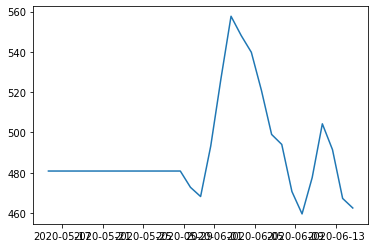





KDJ
                             K          D           J
time                                                 
2020-05-15 16:00:00  47.941123  49.313708   45.195954
2020-05-16 16:00:00  54.916837  51.181417   62.387675
2020-05-17 16:00:00  60.078348  54.147061   71.940921
2020-05-18 16:00:00  65.418898  57.904340   80.448015
2020-05-19 16:00:00  56.919905  57.576195   55.607325
2020-05-20 16:00:00  45.395942  53.516111   29.155606
2020-05-21 16:00:00  40.689806  49.240676   23.588066
2020-05-22 16:00:00  37.821104  45.434152   22.595009
2020-05-23 16:00:00  25.756469  38.874924   -0.480441
2020-05-24 16:00:00  23.740090  33.829980    3.560311
2020-05-25 16:00:00  20.887107  29.515689    3.629942
2020-05-26 16:00:00  28.840494  29.290624   27.940234
2020-05-27 16:00:00  45.163947  34.581731   66.328378
2020-05-28 16:00:00  56.713215  41.958893   86.221861
2020-05-29 16:00:00  69.857756  51.258514  107.056239
2020-05-30 16:00:00  71.042954  57.853327   97.422207
2020-05-31 16:00:00 

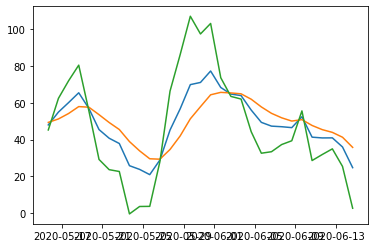





MACD
                          MACD  signal_line  histogram
time                                                  
2020-05-15 16:00:00   6.703173     6.703173   0.000000
2020-05-16 16:00:00   6.703173     6.703173   0.000000
2020-05-17 16:00:00  10.212299     8.141339   2.070959
2020-05-18 16:00:00  13.059992     9.807550   3.252443
2020-05-19 16:00:00   3.823294     8.027369  -4.204075
2020-05-20 16:00:00 -20.734612     0.231273 -20.965885
2020-05-21 16:00:00 -31.535363    -7.808015 -23.727348
2020-05-22 16:00:00 -37.835380   -15.024156 -22.811224
2020-05-23 16:00:00 -64.385576   -26.426889 -37.958687
2020-05-24 16:00:00 -73.010638   -36.864353 -36.146286
2020-05-25 16:00:00 -81.371647   -46.602294 -34.769352
2020-05-26 16:00:00 -66.460578   -50.867021 -15.593557
2020-05-27 16:00:00 -33.517067   -47.195168  13.678101
2020-05-28 16:00:00 -17.048131   -40.888385  23.840254
2020-05-29 16:00:00  11.650248   -29.997469  41.647716
2020-05-30 16:00:00  18.150909   -20.088891  38.239800
2

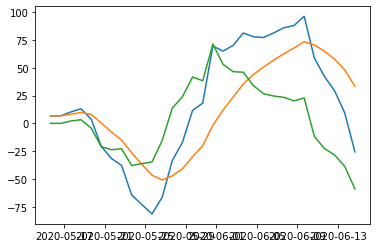





RSI
time
2020-05-15 16:00:00    100.000000
2020-05-16 16:00:00    100.000000
2020-05-17 16:00:00    100.000000
2020-05-18 16:00:00    100.000000
2020-05-19 16:00:00     51.438451
2020-05-20 16:00:00     26.170603
2020-05-21 16:00:00     35.013424
2020-05-22 16:00:00     35.805520
2020-05-23 16:00:00     21.006472
2020-05-24 16:00:00     34.004534
2020-05-25 16:00:00     32.045112
2020-05-26 16:00:00     51.822008
2020-05-27 16:00:00     63.789599
2020-05-28 16:00:00     57.454422
2020-05-29 16:00:00     64.887486
2020-05-30 16:00:00     54.960942
2020-05-31 16:00:00     70.877615
2020-06-01 16:00:00     52.788664
2020-06-02 16:00:00     55.815616
2020-06-03 16:00:00     58.331147
2020-06-04 16:00:00     53.579888
2020-06-05 16:00:00     54.743378
2020-06-06 16:00:00     56.958109
2020-06-07 16:00:00     57.979368
2020-06-08 16:00:00     57.549902
2020-06-09 16:00:00     61.427505
2020-06-10 16:00:00     39.385850
2020-06-11 16:00:00     46.583401
2020-06-12 16:00:00     46.900427
2

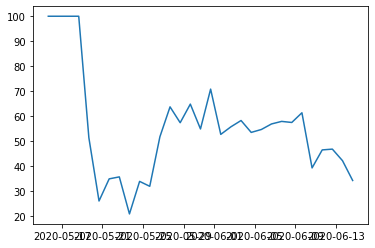





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-10 16:00:00  0.334647  0.126075  0.200876
2020-06-11 16:00:00  0.318664  0.103192  0.164416
2020-06-12 16:00:00  0.317868  0.091542  0.175073
2020-06-13 16:00:00  0.335346  0.083268  0.212770


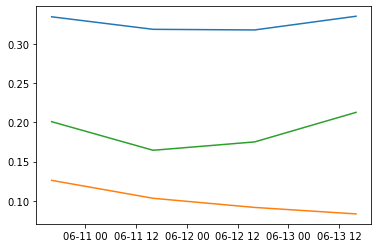





bollinger_bands
                           BB_up      BB_down    BB_width
time                                                     
2020-06-03 16:00:00  9424.450000  9424.450000    0.000000
2020-06-04 16:00:00  9439.126552  9433.762448    5.364103
2020-06-05 16:00:00  9439.345333  9432.169667    7.175667
2020-06-06 16:00:00  9440.718442  9432.102558    8.615884
2020-06-07 16:00:00  9441.615474  9431.853526    9.761948
2020-06-08 16:00:00  9456.825513  9442.743487   14.082025
2020-06-09 16:00:00  9506.190623  9475.013377   31.177247
2020-06-10 16:00:00  9517.273893  9474.970107   42.303787
2020-06-11 16:00:00  9537.283863  9483.558137   53.725727
2020-06-12 16:00:00  9584.025031  9512.116969   71.908062
2020-06-13 16:00:00  9615.235324  9525.081676   90.153648
2020-06-14 16:00:00  9635.072521  9529.146479  105.926043


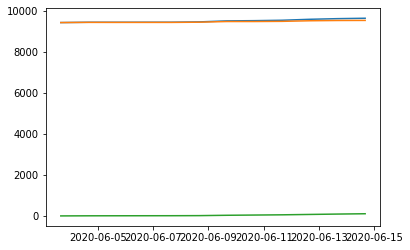





commodity_channel_index
time
2020-05-15 16:00:00         NaN
2020-05-16 16:00:00         NaN
2020-05-17 16:00:00         NaN
2020-05-18 16:00:00         NaN
2020-05-19 16:00:00         NaN
2020-05-20 16:00:00         NaN
2020-05-21 16:00:00         NaN
2020-05-22 16:00:00         NaN
2020-05-23 16:00:00         NaN
2020-05-24 16:00:00         NaN
2020-05-25 16:00:00         NaN
2020-05-26 16:00:00         NaN
2020-05-27 16:00:00         NaN
2020-05-28 16:00:00         NaN
2020-05-29 16:00:00         NaN
2020-05-30 16:00:00         NaN
2020-05-31 16:00:00         NaN
2020-06-01 16:00:00         NaN
2020-06-02 16:00:00         NaN
2020-06-03 16:00:00    0.922981
2020-06-04 16:00:00    0.799156
2020-06-05 16:00:00    0.671269
2020-06-06 16:00:00    0.678043
2020-06-07 16:00:00    0.967775
2020-06-08 16:00:00    0.927010
2020-06-09 16:00:00    1.156748
2020-06-10 16:00:00   -0.077755
2020-06-11 16:00:00   -0.218882
2020-06-12 16:00:00   -0.258084
2020-06-13 16:00:00   -0.726304
2020-06

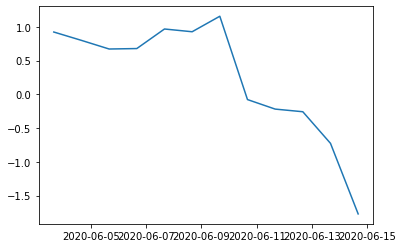





exponential_moving_average
                            open          high          low        close  \
time                                                                       
2020-05-15 16:00:00  9315.960000   9588.000000  9220.000000  9381.270000   
2020-05-16 16:00:00  9364.597500   9813.000000  9296.575000  9605.347500   
2020-05-17 16:00:00  9583.721538   9907.846154  9412.643846  9694.366154   
2020-05-18 16:00:00  9685.112250   9900.666750  9454.059250  9749.151750   
2020-05-19 16:00:00  9745.372066   9861.393967  9368.333636  9590.015702   
2020-05-20 16:00:00  9589.196456   9672.518901  8998.937830  9241.961126   
2020-05-21 16:00:00  9241.246386   9404.717182  8955.305993  9193.965096   
2020-05-22 16:00:00  9193.741555   9340.129216  9031.780320  9184.086860   
2020-05-23 16:00:00  9183.920019   9312.041645  8810.582202  8874.906579   
2020-05-24 16:00:00  8873.394748   9090.450129  8698.672172  8891.869147   
2020-05-25 16:00:00  8891.365017   9041.929769  8699.5573

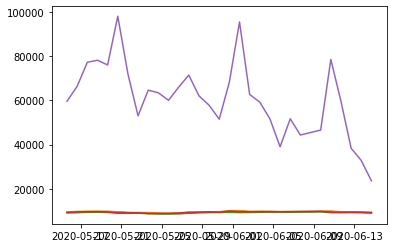





heikin_ashi
                            open          high          low      close
2020-05-15 16:00:00  9315.960000   9588.000000  9220.000000  9376.3075
2020-05-16 16:00:00  9346.133750   9888.000000  9322.100000  9567.7375
2020-05-17 16:00:00  9456.935625   9950.000000  9456.935625  9707.3175
2020-05-18 16:00:00  9582.126562   9897.210000  9474.000000  9720.1675
2020-05-19 16:00:00  9651.147031   9842.000000  9326.000000  9613.6400
2020-05-20 16:00:00  9632.393516   9632.393516  8815.000000  9243.3875
2020-05-21 16:00:00  9437.890508   9437.890508  8933.520000  9110.5075
2020-05-22 16:00:00  9274.199004   9307.850000  9070.000000  9181.7500
2020-05-23 16:00:00  9227.974502   9298.000000  8700.000000  8974.3375
2020-05-24 16:00:00  9101.156001   9101.156001  8642.720000  8810.2175
2020-05-25 16:00:00  8955.686750   9017.670000  8700.000000  8864.8000
2020-05-26 16:00:00  8910.243375   9225.000000  8811.730000  9020.4500
2020-05-27 16:00:00  8965.346688   9625.470000  8965.346688  

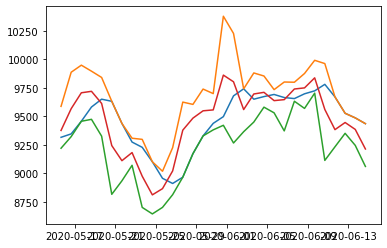





relative_volume_level
volume    0.0
dtype: float64


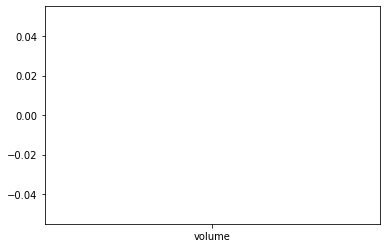





renko
time
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-16 16:00:00    1.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-14 16:00:00    0.0
Name: uptrend, Length: 6622, dtype: float64


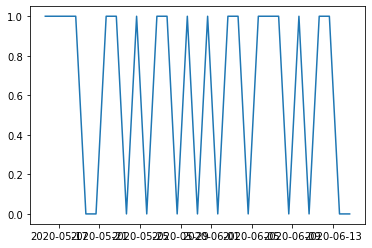





simple_moving_average
                         open       high       low     close        volume
time                                                                      
2020-05-15 16:00:00  9348.385   9738.000  9271.050  9530.655  64117.696093
2020-05-16 16:00:00  9348.385   9738.000  9271.050  9530.655  64117.696093
2020-05-17 16:00:00  9530.960   9919.000  9393.165  9706.985  75327.183953
2020-05-18 16:00:00  9707.520   9923.605  9469.115  9754.730  80273.182019
2020-05-19 16:00:00  9754.530   9869.605  9400.000  9643.480  76731.749272
2020-05-20 16:00:00  9643.280   9710.235  9070.500  9290.040  91926.259530
2020-05-21 16:00:00  9289.470   9424.735  8874.260  9119.325  83935.955997
2020-05-22 16:00:00  9118.755   9289.425  9001.760  9174.575  51234.713995
2020-05-23 16:00:00  9174.505   9302.925  8885.000  8949.745  56953.081708
2020-05-24 16:00:00  8948.575   9138.830  8671.360  8810.345  66606.888700
2020-05-25 16:00:00  8809.245   8998.665  8671.360  8870.765  60566.840544

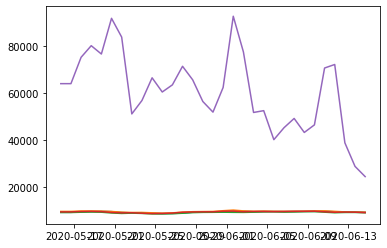





MACD_trigger
time
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
Name: histogram, dtype: float64


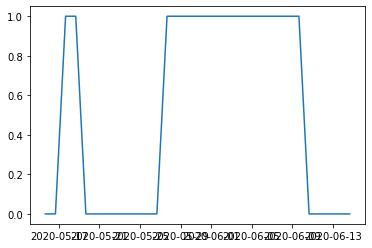





momentum_trigger
time
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    0.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    0.0
2020-06-06 16:00:00    0.0
2020-06-07 16:00:00    0.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
dtype: float64


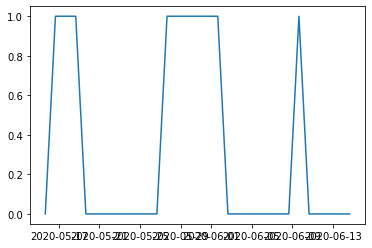





overtraded_trigger
time
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    0.0
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    0.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
Name: close, dtype: float64


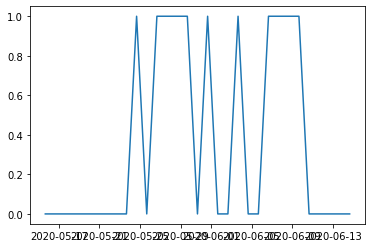





real_trigger
time
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
dtype: float64


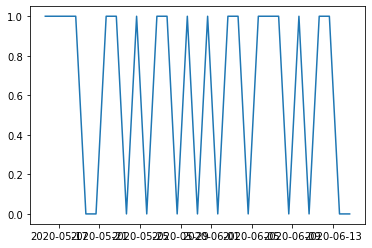





trend_strength_negative_trigger
time
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
dtype: float64


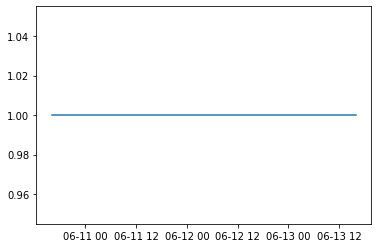





trend_strength_positive_trigger
time
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
dtype: float64


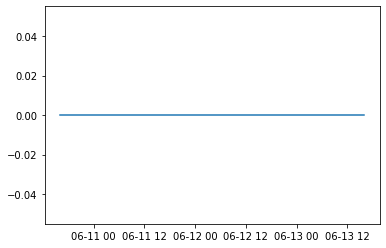





trend_strength_trigger
time
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
Name: ADX, dtype: float64


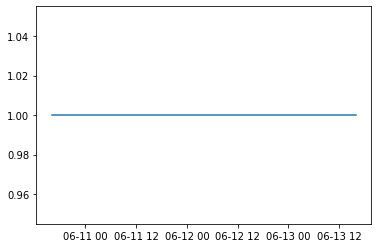





trend_trigger
time
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
dtype: float64


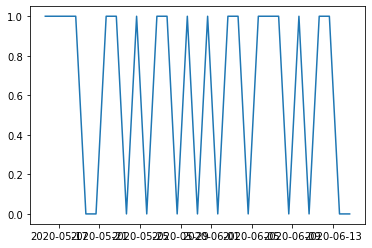





volatility_trigger
time
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    0.0
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    0.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    0.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    0.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    0.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
dtype: float64


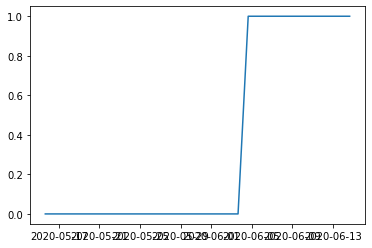





ATR
time
2020-05-15 16:00:00    480.864072
2020-05-16 16:00:00    480.864072
2020-05-17 16:00:00    480.864072
2020-05-18 16:00:00    480.864072
2020-05-19 16:00:00    480.864072
2020-05-20 16:00:00    480.864072
2020-05-21 16:00:00    480.864072
2020-05-22 16:00:00    480.864072
2020-05-23 16:00:00    480.864072
2020-05-24 16:00:00    480.864072
2020-05-25 16:00:00    480.864072
2020-05-26 16:00:00    480.864072
2020-05-27 16:00:00    480.864072
2020-05-28 16:00:00    480.864072
2020-05-29 16:00:00    472.782353
2020-05-30 16:00:00    468.210042
2020-05-31 16:00:00    493.292182
2020-06-01 16:00:00    526.509169
2020-06-02 16:00:00    557.686371
2020-06-03 16:00:00    548.126630
2020-06-04 16:00:00    539.805442
2020-06-05 16:00:00    520.801482
2020-06-06 16:00:00    499.025662
2020-06-07 16:00:00    494.062400
2020-06-08 16:00:00    470.700800
2020-06-09 16:00:00    459.579315
2020-06-10 16:00:00    477.632221
2020-06-11 16:00:00    504.301348
2020-06-12 16:00:00    491.466252
2

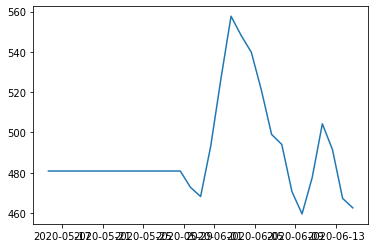





KDJ
                             K          D           J
time                                                 
2020-05-15 16:00:00  47.941123  49.313708   45.195954
2020-05-16 16:00:00  54.916837  51.181417   62.387675
2020-05-17 16:00:00  60.078348  54.147061   71.940921
2020-05-18 16:00:00  65.418898  57.904340   80.448015
2020-05-19 16:00:00  56.919905  57.576195   55.607325
2020-05-20 16:00:00  45.395942  53.516111   29.155606
2020-05-21 16:00:00  40.689806  49.240676   23.588066
2020-05-22 16:00:00  37.821104  45.434152   22.595009
2020-05-23 16:00:00  25.756469  38.874924   -0.480441
2020-05-24 16:00:00  23.740090  33.829980    3.560311
2020-05-25 16:00:00  20.887107  29.515689    3.629942
2020-05-26 16:00:00  28.840494  29.290624   27.940234
2020-05-27 16:00:00  45.163947  34.581731   66.328378
2020-05-28 16:00:00  56.713215  41.958893   86.221861
2020-05-29 16:00:00  69.857756  51.258514  107.056239
2020-05-30 16:00:00  71.042954  57.853327   97.422207
2020-05-31 16:00:00 

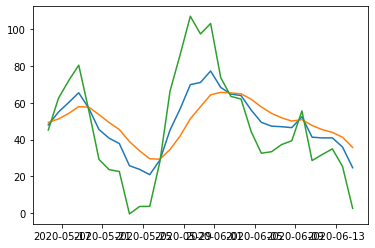





MACD
                          MACD  signal_line  histogram
time                                                  
2020-05-15 16:00:00   6.703173     6.703173   0.000000
2020-05-16 16:00:00   6.703173     6.703173   0.000000
2020-05-17 16:00:00  10.212299     8.141339   2.070959
2020-05-18 16:00:00  13.059992     9.807550   3.252443
2020-05-19 16:00:00   3.823294     8.027369  -4.204075
2020-05-20 16:00:00 -20.734612     0.231273 -20.965885
2020-05-21 16:00:00 -31.535363    -7.808015 -23.727348
2020-05-22 16:00:00 -37.835380   -15.024156 -22.811224
2020-05-23 16:00:00 -64.385576   -26.426889 -37.958687
2020-05-24 16:00:00 -73.010638   -36.864353 -36.146286
2020-05-25 16:00:00 -81.371647   -46.602294 -34.769352
2020-05-26 16:00:00 -66.460578   -50.867021 -15.593557
2020-05-27 16:00:00 -33.517067   -47.195168  13.678101
2020-05-28 16:00:00 -17.048131   -40.888385  23.840254
2020-05-29 16:00:00  11.650248   -29.997469  41.647716
2020-05-30 16:00:00  18.150909   -20.088891  38.239800
2

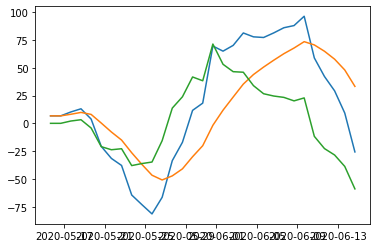





RSI
time
2020-05-15 16:00:00    100.000000
2020-05-16 16:00:00    100.000000
2020-05-17 16:00:00    100.000000
2020-05-18 16:00:00    100.000000
2020-05-19 16:00:00     51.438451
2020-05-20 16:00:00     26.170603
2020-05-21 16:00:00     35.013424
2020-05-22 16:00:00     35.805520
2020-05-23 16:00:00     21.006472
2020-05-24 16:00:00     34.004534
2020-05-25 16:00:00     32.045112
2020-05-26 16:00:00     51.822008
2020-05-27 16:00:00     63.789599
2020-05-28 16:00:00     57.454422
2020-05-29 16:00:00     64.887486
2020-05-30 16:00:00     54.960942
2020-05-31 16:00:00     70.877615
2020-06-01 16:00:00     52.788664
2020-06-02 16:00:00     55.815616
2020-06-03 16:00:00     58.331147
2020-06-04 16:00:00     53.579888
2020-06-05 16:00:00     54.743378
2020-06-06 16:00:00     56.958109
2020-06-07 16:00:00     57.979368
2020-06-08 16:00:00     57.549902
2020-06-09 16:00:00     61.427505
2020-06-10 16:00:00     39.385850
2020-06-11 16:00:00     46.583401
2020-06-12 16:00:00     46.900427
2

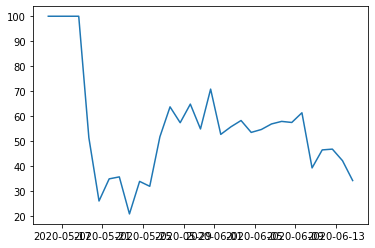





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-06-10 16:00:00  0.334647  0.126075  0.200876
2020-06-11 16:00:00  0.318664  0.103192  0.164416
2020-06-12 16:00:00  0.317868  0.091542  0.175073
2020-06-13 16:00:00  0.335346  0.083268  0.212770


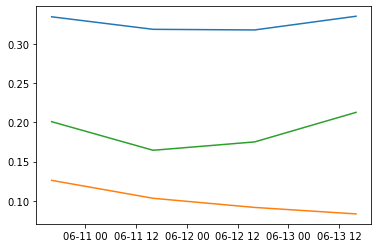





bollinger_bands
                           BB_up      BB_down    BB_width
time                                                     
2020-06-03 16:00:00  9424.450000  9424.450000    0.000000
2020-06-04 16:00:00  9439.126552  9433.762448    5.364103
2020-06-05 16:00:00  9439.345333  9432.169667    7.175667
2020-06-06 16:00:00  9440.718442  9432.102558    8.615884
2020-06-07 16:00:00  9441.615474  9431.853526    9.761948
2020-06-08 16:00:00  9456.825513  9442.743487   14.082025
2020-06-09 16:00:00  9506.190623  9475.013377   31.177247
2020-06-10 16:00:00  9517.273893  9474.970107   42.303787
2020-06-11 16:00:00  9537.283863  9483.558137   53.725727
2020-06-12 16:00:00  9584.025031  9512.116969   71.908062
2020-06-13 16:00:00  9615.235324  9525.081676   90.153648
2020-06-14 16:00:00  9635.014245  9529.100755  105.913490


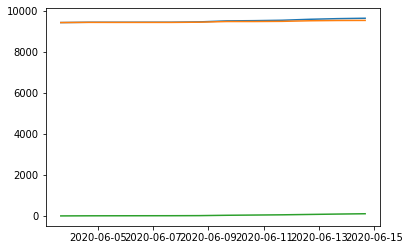





commodity_channel_index
time
2020-05-15 16:00:00         NaN
2020-05-16 16:00:00         NaN
2020-05-17 16:00:00         NaN
2020-05-18 16:00:00         NaN
2020-05-19 16:00:00         NaN
2020-05-20 16:00:00         NaN
2020-05-21 16:00:00         NaN
2020-05-22 16:00:00         NaN
2020-05-23 16:00:00         NaN
2020-05-24 16:00:00         NaN
2020-05-25 16:00:00         NaN
2020-05-26 16:00:00         NaN
2020-05-27 16:00:00         NaN
2020-05-28 16:00:00         NaN
2020-05-29 16:00:00         NaN
2020-05-30 16:00:00         NaN
2020-05-31 16:00:00         NaN
2020-06-01 16:00:00         NaN
2020-06-02 16:00:00         NaN
2020-06-03 16:00:00    0.922981
2020-06-04 16:00:00    0.799156
2020-06-05 16:00:00    0.671269
2020-06-06 16:00:00    0.678043
2020-06-07 16:00:00    0.967775
2020-06-08 16:00:00    0.927010
2020-06-09 16:00:00    1.156748
2020-06-10 16:00:00   -0.077755
2020-06-11 16:00:00   -0.218882
2020-06-12 16:00:00   -0.258084
2020-06-13 16:00:00   -0.726304
2020-06

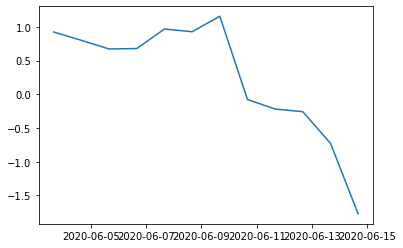





exponential_moving_average
                            open          high          low        close  \
time                                                                       
2020-05-15 16:00:00  9315.960000   9588.000000  9220.000000  9381.270000   
2020-05-16 16:00:00  9364.597500   9813.000000  9296.575000  9605.347500   
2020-05-17 16:00:00  9583.721538   9907.846154  9412.643846  9694.366154   
2020-05-18 16:00:00  9685.112250   9900.666750  9454.059250  9749.151750   
2020-05-19 16:00:00  9745.372066   9861.393967  9368.333636  9590.015702   
2020-05-20 16:00:00  9589.196456   9672.518901  8998.937830  9241.961126   
2020-05-21 16:00:00  9241.246386   9404.717182  8955.305993  9193.965096   
2020-05-22 16:00:00  9193.741555   9340.129216  9031.780320  9184.086860   
2020-05-23 16:00:00  9183.920019   9312.041645  8810.582202  8874.906579   
2020-05-24 16:00:00  8873.394748   9090.450129  8698.672172  8891.869147   
2020-05-25 16:00:00  8891.365017   9041.929769  8699.5573

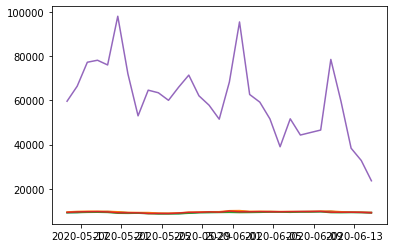





heikin_ashi
                            open          high          low      close
2020-05-15 16:00:00  9315.960000   9588.000000  9220.000000  9376.3075
2020-05-16 16:00:00  9346.133750   9888.000000  9322.100000  9567.7375
2020-05-17 16:00:00  9456.935625   9950.000000  9456.935625  9707.3175
2020-05-18 16:00:00  9582.126562   9897.210000  9474.000000  9720.1675
2020-05-19 16:00:00  9651.147031   9842.000000  9326.000000  9613.6400
2020-05-20 16:00:00  9632.393516   9632.393516  8815.000000  9243.3875
2020-05-21 16:00:00  9437.890508   9437.890508  8933.520000  9110.5075
2020-05-22 16:00:00  9274.199004   9307.850000  9070.000000  9181.7500
2020-05-23 16:00:00  9227.974502   9298.000000  8700.000000  8974.3375
2020-05-24 16:00:00  9101.156001   9101.156001  8642.720000  8810.2175
2020-05-25 16:00:00  8955.686750   9017.670000  8700.000000  8864.8000
2020-05-26 16:00:00  8910.243375   9225.000000  8811.730000  9020.4500
2020-05-27 16:00:00  8965.346688   9625.470000  8965.346688  

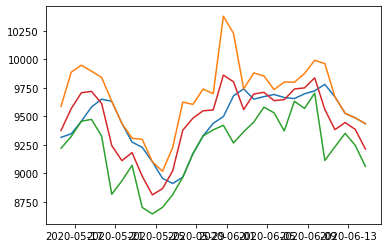





relative_volume_level
volume    0.0
dtype: float64


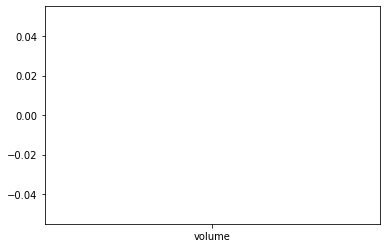





renko
time
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-16 16:00:00    1.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-14 16:00:00    0.0
Name: uptrend, Length: 6623, dtype: float64


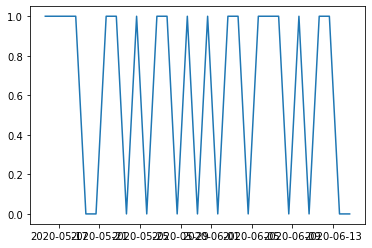





simple_moving_average
                         open       high       low     close        volume
time                                                                      
2020-05-15 16:00:00  9348.385   9738.000  9271.050  9530.655  64117.696093
2020-05-16 16:00:00  9348.385   9738.000  9271.050  9530.655  64117.696093
2020-05-17 16:00:00  9530.960   9919.000  9393.165  9706.985  75327.183953
2020-05-18 16:00:00  9707.520   9923.605  9469.115  9754.730  80273.182019
2020-05-19 16:00:00  9754.530   9869.605  9400.000  9643.480  76731.749272
2020-05-20 16:00:00  9643.280   9710.235  9070.500  9290.040  91926.259530
2020-05-21 16:00:00  9289.470   9424.735  8874.260  9119.325  83935.955997
2020-05-22 16:00:00  9118.755   9289.425  9001.760  9174.575  51234.713995
2020-05-23 16:00:00  9174.505   9302.925  8885.000  8949.745  56953.081708
2020-05-24 16:00:00  8948.575   9138.830  8671.360  8810.345  66606.888700
2020-05-25 16:00:00  8809.245   8998.665  8671.360  8870.765  60566.840544

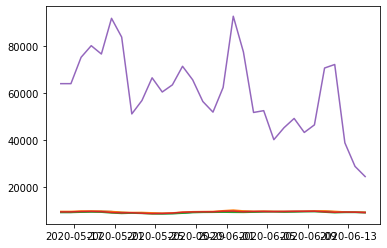





MACD_trigger
time
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
Name: histogram, dtype: float64


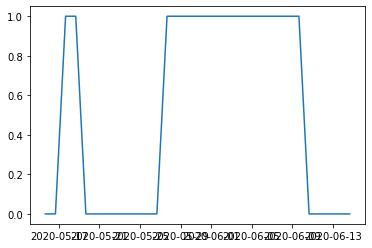





momentum_trigger
time
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    1.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    1.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    0.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    0.0
2020-06-06 16:00:00    0.0
2020-06-07 16:00:00    0.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
dtype: float64


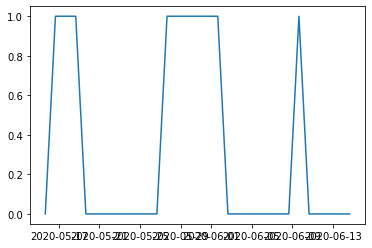





overtraded_trigger
time
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    0.0
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    1.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    0.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
Name: close, dtype: float64


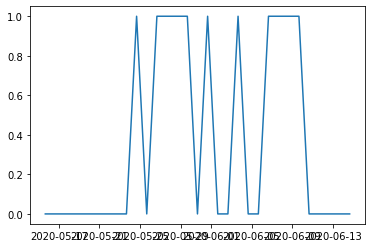





real_trigger
time
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
dtype: float64


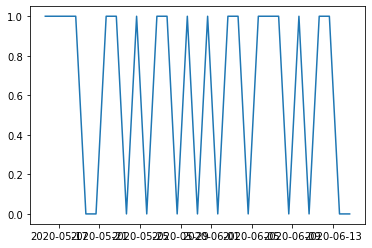





trend_strength_negative_trigger
time
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
dtype: float64


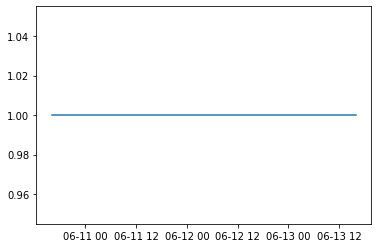





trend_strength_positive_trigger
time
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    0.0
2020-06-12 16:00:00    0.0
2020-06-13 16:00:00    0.0
dtype: float64


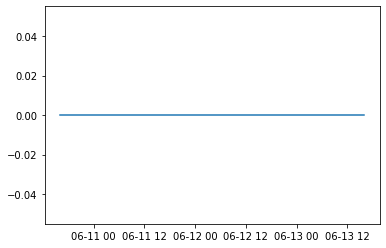





trend_strength_trigger
time
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
Name: ADX, dtype: float64


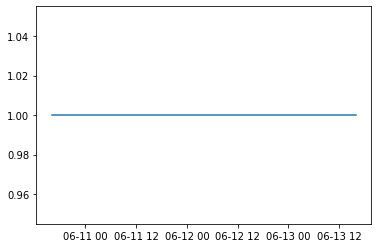





trend_trigger
time
2020-05-15 16:00:00    1.0
2020-05-16 16:00:00    1.0
2020-05-17 16:00:00    1.0
2020-05-18 16:00:00    1.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    1.0
2020-05-22 16:00:00    1.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    1.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    1.0
2020-05-27 16:00:00    1.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    1.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    1.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    1.0
2020-06-03 16:00:00    1.0
2020-06-04 16:00:00    0.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    0.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    0.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
dtype: float64


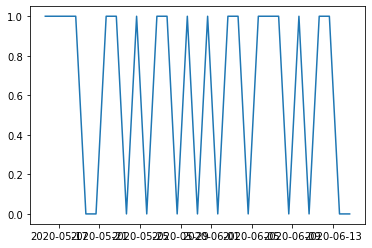





volatility_trigger
time
2020-05-15 16:00:00    0.0
2020-05-16 16:00:00    0.0
2020-05-17 16:00:00    0.0
2020-05-18 16:00:00    0.0
2020-05-19 16:00:00    0.0
2020-05-20 16:00:00    0.0
2020-05-21 16:00:00    0.0
2020-05-22 16:00:00    0.0
2020-05-23 16:00:00    0.0
2020-05-24 16:00:00    0.0
2020-05-25 16:00:00    0.0
2020-05-26 16:00:00    0.0
2020-05-27 16:00:00    0.0
2020-05-28 16:00:00    0.0
2020-05-29 16:00:00    0.0
2020-05-30 16:00:00    0.0
2020-05-31 16:00:00    0.0
2020-06-01 16:00:00    0.0
2020-06-02 16:00:00    0.0
2020-06-03 16:00:00    0.0
2020-06-04 16:00:00    1.0
2020-06-05 16:00:00    1.0
2020-06-06 16:00:00    1.0
2020-06-07 16:00:00    1.0
2020-06-08 16:00:00    1.0
2020-06-09 16:00:00    1.0
2020-06-10 16:00:00    1.0
2020-06-11 16:00:00    1.0
2020-06-12 16:00:00    1.0
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
dtype: float64


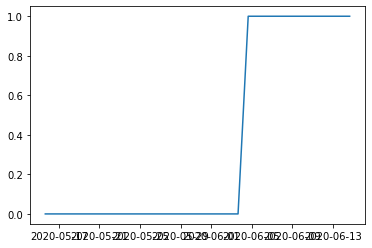

In [5]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                period=period, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot)

In [6]:
def process_message(msg):
    global crypto_bot
    four_hours = 14400
    milliseconds = 1000
    percentage_to_trade = 0.9999

    msg = msg['data']['k']
    symbol = msg['s']
    interval = msg['i']
    pair = crypto_bot.pairs[symbol]
    pair_at_interval = pair.interval[interval]
    dataset = pair_at_interval.dataset
    precision = pair.info.precision
    if symbol in crypto_bot.pairs.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        pair_at_interval.dataset = dataset
        pair_at_interval.indicators.update(dataset, plot=False)
        pair.info.calculate_balance()
        pair.info.print_balance()

        if symbol == crypto_bot.traded_pair_symbol:
            volatility_trigger = pair_at_interval.indicators.volatility_trigger.value.iloc[-1]
            MACD_trigger = pair_at_interval.indicators.MACD_trigger.value.iloc[-1]
            real_trigger = pair_at_interval.indicators.real_trigger.value.iloc[-1]
            momentum_trigger = pair_at_interval.indicators.momentum_trigger.value.iloc[-1]

            if pair.state == 'exit':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

            elif pair.state == 'entry':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for symbol in crypto_bot.pairs.keys():
        sockets.append(symbol.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)

bm.start()

'''
scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(15)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol
'''

"\nscores = {}\nfor crypto_pair in symbols.values():\n    scores.update({crypto_pair.base_asset: 0})\n    scores.update({crypto_pair.quote_asset: 0})\n\nwhile True:\n    time.sleep(15)\n    for symbol in symbols.keys():\n        symbols[symbol].calculate_balance()\n        symbols[symbol].calculate_position()\n\n    scores = {}\n    for crypto_pair in symbols.values():\n        scores.update({crypto_pair.base_asset: 0})\n        scores.update({crypto_pair.quote_asset: 0})\n\n    for asset in scores.keys():\n        for symbol in symbols.keys():\n            if symbols[symbol].base_asset == asset:\n                if symbols[symbol].real_trigger.iloc[-1] and                         symbols[symbol].real_trigger_10m.iloc[-1]:\n                    scores.update({asset: scores[asset] + 1})\n                else:\n                    scores.update({asset: scores[asset] - 1})\n            elif symbols[symbol].quote_asset == asset:\n                if symbols[symbol].real_trigger.iloc[-1] and 

In [7]:
# --- Development separation --- #

In [8]:
'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''

'\ndef process_message(msg):\n    global symbols, traded_symbol\n    four_hours = 14400\n    milliseconds = 1000\n\n    msg = msg[\'data\'][\'k\']\n    symbol = msg[\'s\']\n    dataset = symbols[symbol].dataset\n    quote_asset_precision = symbols[symbol].quote_asset_precision\n    if symbol in symbols.keys():\n        last_data =             pd.DataFrame([["{:0.0{}f}".format(float(msg[\'o\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'h\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'l\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'c\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\'), \n                           "{:0.0{}f}".format(float(msg[\'v\']), quote_asset_precision).rstrip(\'0\').rstrip(\'.\')]], \n                         index=[datetime.datetime.fromtimestamp(int(ms

In [9]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()

base_asset_balance:  0.00468866
quote_asset_balance:  0.0
pair_last_price:  9080.0
pair_buy_balance:  0.0
pair_sell_balance:  42.5730328
pair_combined_base_balance:  0.00468866
pair_combined_quote_balance:  42.5730328


Unhandled Error
Traceback (most recent call last):
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 103, in callWithLogger
    return callWithContext({"system": lp}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 86, in callWithContext
    return context.call({ILogContext: newCtx}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 122, in callWithContext
    return self.currentContext().callWithContext(ctx, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 85, in callWithContext
    return func(*args,**kw)
--- <exception caught here> ---
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/posixbase.py", line 614, in _doReadOrWrite
    why = selectable.doRead()
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/tcp.py", l

base_asset_balance:  0.00468866
quote_asset_balance:  0.0
pair_last_price:  9080.84
pair_buy_balance:  0.0
pair_sell_balance:  42.5769712744
pair_combined_base_balance:  0.00468866
pair_combined_quote_balance:  42.5769712744


Unhandled Error
Traceback (most recent call last):
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 103, in callWithLogger
    return callWithContext({"system": lp}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/log.py", line 86, in callWithContext
    return context.call({ILogContext: newCtx}, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 122, in callWithContext
    return self.currentContext().callWithContext(ctx, func, *args, **kw)
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/python/context.py", line 85, in callWithContext
    return func(*args,**kw)
--- <exception caught here> ---
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/posixbase.py", line 614, in _doReadOrWrite
    why = selectable.doRead()
  File "/home/samuel/anaconda3/lib/python3.7/site-packages/twisted/internet/tcp.py", l